<center><h1>  1. zadaća </h1></center>
<center><h1>Algoritmi za određivanje konveksne ljuske skupa točaka </h1></center>

<h2> Uvod </h2>

Za početak ćemo definirati osnovne pojmove vezane uz temu ovoga rada. Kažemo da je skup $ D \subseteq \mathbb{R}^{n} $ konveksan ako za bilo koje dvije točke $ x_{1}, x_{2} \in \mathbb{R}^{n} $ sadrži i segment određen tim točkama.

$$ x_{1}, x_{2} \in D \Rightarrow \lambda x_{1} + ( 1 - \lambda ) x_{2}  \in D , \:\: \forall \lambda \in [ 0, 1 ]$$


In [88]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

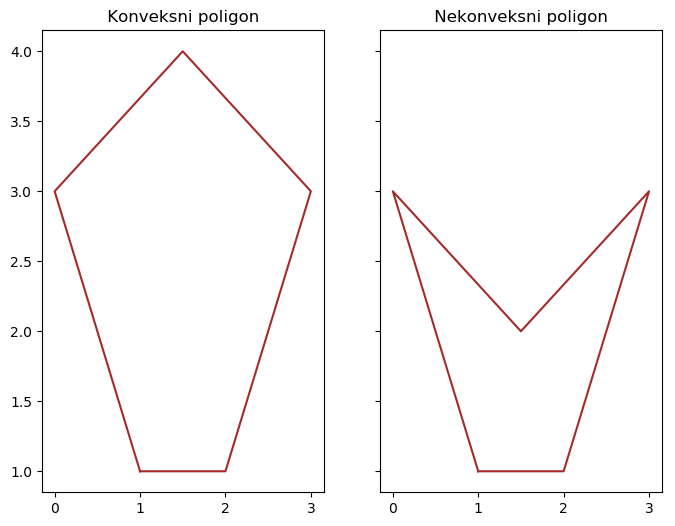

In [1]:
import matplotlib.pyplot as plt
import numpy as np

Convex = [[1,1], [2,1], [3,3], [1.5,4], [0, 3]]
Convex.append(Convex[0]) 
x, y = zip(*Convex) 

notConvex = [[1,1], [2,1], [3,3], [1.5,2], [0, 3]]
notConvex.append(notConvex[0]) 
x_, y_ = zip(*notConvex)

plot_difference, (left, right ) = plt.subplots(1, 2, figsize=(8,6), sharey=True)
left.plot( x, y, color='brown')
left.set_title(" Konveksni poligon ")
right.plot( x_, y_, color='brown')
right.set_title(" Nekonveksni poligon ")

%matplotlib inline

plot_difference
#smanjiti grafove !!

Nadalje, neka je skup $ S  \subseteq \mathbb{R}^{n}$. Konveksna ljuska skupa $ S $ je skup svih konveksnih kombinacija točaka iz $ S $. 
$$ conv(S) = \{ \lambda_{1}x_{1} + \lambda_{2}x_{2} + ... + \lambda_{m}x_{m} : x_{1}, x_{2}, ... , x_{m} \in S, \: \lambda_{1}, \lambda_{2}, ... , \lambda_{m} \in [0, 1],  \sum\limits_{1}^{m} \lambda_{i} = 1 \} $$
Drugim riječima, konveksna ljuska je najmanji konveksni skup koji sadrži skup S.

Using matplotlib backend: Qt5Agg


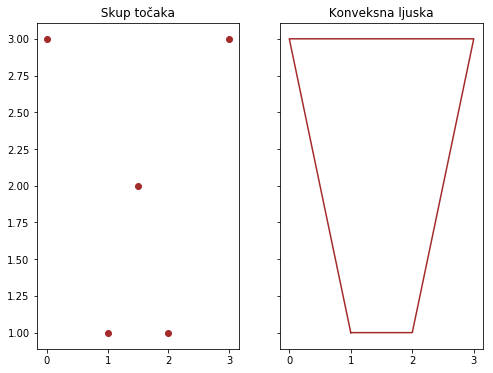

In [2]:
%matplotlib

Set = [[1,1], [2,1], [3,3], [1.5,2], [0, 3]]
ConvexHull = [[1,1], [2,1], [3,3], [0, 3]]
ConvexHull.append(ConvexHull[0])
x1, y1 = zip(*ConvexHull)
x2, y2 = zip(*Set) 
 

Hull_of_Set, (left_, right_ ) = plt.subplots(1, 2, figsize=(8, 6), sharey=True)
left_.scatter( x2, y2, color='brown', ) 
left_.set_title(" Skup točaka ")
right_.plot( x1, y1, color='brown')
right_.set_title(" Konveksna ljuska ")

%matplotlib inline

Hull_of_Set

<h3> O algoritmima </h3> 

U ovom radu baviti ćemo se određivanjem konveksne ljuske nekog skupa točaka iz ravnine. 


In [3]:
# izrada klase Točka
# ne koristiti 
class Point:
    def __init__(self, x_, y_):
        self.x = x_
        self.y = y_
    
import random as rand

# generiranje skupa od 100 random točaka, upisati ih u neki file?
array_ = []
for x in range(100):
    x = rand.randint(1,100)
    y = rand.randint(1,100)
    point = Point(x,y)
    array_.append(point)
# ispis točaka
#for x in range(100):
#    print(lista_tocaka[x].x,", ",lista_tocaka[x].y)

In [4]:
# funkcija lijeva_baza provjerava u kojem smjeru se tocka C nastavlja na segment AB
# vraca pozitivan rezultat ukoliko se C nalazi lijevo gledajuci od A prema B pa k C
# vraca negativan rezultat ukoliko se C nalazi desno gledajuci od A prema B pa k C
# te vraca nulu ukoliko su te tri tocke kolinearne

# verzija s klasom
def left_turn( point_A, point_B, point_C):
    return (point_A.x * (point_B.y - point_C.y)) + point_B.x * (point_C.y - point_A.y) + point_C.x * (point_A.y - point_B.y);

#verzija s matricama
def Mleft_turn( point_A, point_B, point_C):
    return (point_A[0] * (point_B[1] - point_C[1])) + point_B[0] * (point_C[1] - point_A[1]) + point_C[0] * (point_A[1] - point_B[1]);

#provjeriti u pravilima, kako se ovi dugi izrazi pravilno zapisuju

In [5]:
X = Point(1, 1)
Y = Point(1, 2)
Z = Point(1, 3)

X_ = [1, 1]
Y_ = [1, 2]
Z_ = [1, 3]


print( Mleft_turn(X_,Y_,Z_) )

print( left_turn(X,Y,Z) )
Z = Point(3,3)

print( left_turn(X,Y,Z))

Z = Point(0, 7)
print( left_turn(X,Y,Z))

0
0
-2
1


In [6]:
# kako nam trebaju samo omjeri udaljenosti, a ne same vrijednosti udaljenosti možemo računati kvadrat,
# te izostaviti računanje korijena
def distance( point_A, point_B):
    return (point_A.x - point_B.x)**2 + (point_A.y - point_B.y)**2;

def Mdistance( point_A, point_B):
    return (point_A[0] - point_B[0])**2 + (point_A[1] - point_B[1])**2;

In [7]:
print( distance(X,Y) > distance(Y,Z))
print( distance(X,Y) >= distance(Y,X))

False
True


In [8]:
# kao početnu točku tražim najnižu točku ili onu najlijeviju, dakle onu s najmanjom y vrijednosti
# ukoliko dvije točke imaju jednaku najmanju y vrijednost, tražimo onu "lijeviju", dakle s manjom x vrijednosti
def lowest_point( array_points ):
    minY = array_points[0]
    for point in array_points:
        if ( ( point.y < minY.y ) or ( point.y == minY.y and point.x < minY.x ) ):
            minY = point
    return minY 

def Mlowest_point( array_points ):
    minY = array_points[0]
    for point in array_points:
        if ( ( point[1] < minY[1] ) or ( point[1] == minY[1] and point[0] < minY[0] ) ):
            minY = point
    return minY


def leftmost_point( array_points ):
    minX = array_points[0]
    for point in array_points:
        if ( ( point.x < minX.x ) or ( point.x == minX.x and point.y < minX.y ) ):
            minX = point
    return minX 

def Mleftmost_point( array_points ):
    minX = array_points[0]
    for point in array_points:
        if ( ( point[0] < minX[0] ) or ( point[0] == minX[0] and point[1] < minX[1] ) ):
            minX = point
    return minX


In [243]:
array_points2 = []
start = Point(0,0)
for x in range(5):
    x = rand.randint(1,10)
    y = rand.randint(1,10)
    point = Point(x,y)
    array_points2.append(point)
    print("X : ",x,", Y :",y)
start = lowest_point(array_points2)

print(start.x, start.y)

X :  3 , Y : 8
X :  8 , Y : 9
X :  1 , Y : 9
X :  2 , Y : 5
X :  5 , Y : 2
5 2


In [244]:
import functools as func

def function_for_sort( x, y ):  
    global P_0
    coef = Mleft_turn(P_0, x, y)
    if coef > 0 :
        return -1
    elif coef == 0:
        if Mdistance(P_0, x) < Mdistance(P_0, y):
            return -1
    return 1

<h2> Graham algoritam </h2>

- opcenito o algoritmu
- pseudokod
- implementacija ( dio po dio )
- graf
- animacija?

<center><h4> Određivanje konveksne ljuske za skup S koji se sastoji od  n točaka </h4></center> 

1. Odrediti početnu točku, $P_{0}$
2. Sortirati sve ostale točke po polarnom kutu s ozirom na točku $P_{0}$
3. Na stog staviti zadnju pa prvu točku sortirane liste
4. Ponavljati n-2 puta : 
Za sljedeću točku u sortiranoj listi provjeriti čine li    dvije vršne točke sa stoga s njom lijevi okret
<br> Da : stavljamo i novu točku na stog
<br> Ne : izbacujemo točku s vrha stoga


In [276]:
def Graham( array_of_points ):
#    array_size = array_of_points.size();
    new_array = list(array_of_points)
    global P_0 
    P_0 = Mleftmost_point( new_array )
    new_array.remove( P_0 )
    new_array = sorted( new_array, key=func.cmp_to_key(function_for_sort))
    Convex_hull = []
    Convex_hull.append(new_array[-1])
    Convex_hull.append( P_0 )
    index = 0
    size = len(new_array)
    while( index != size ):
        examination_point = new_array[index]
        if ( Mleft_turn( Convex_hull[-2], Convex_hull[-1], examination_point ) > 0 ):
            Convex_hull.append( examination_point )
            index += 1
        else:
            Convex_hull.pop()
    return Convex_hull

# Pogledati prvo pythonov sort!!
# postaviti P_0
# napraviti funkciju za sort i pozvati ju 
# definirati "Stog" 
# krenuti u while petlju
# vratiti sortiran stog 

In [277]:
example = [[1,1], [0,1], [3,3], [1.5,2], [0, 3],[1,2]]
convex = Graham( example )
print("Konveksna ljuska:")

for x in convex:
    print("(",x[0],",",x[1],"), ");



Konveksna ljuska:
( 0 , 3 ), 
( 0 , 1 ), 
( 1 , 1 ), 
( 3 , 3 ), 
( 0 , 3 ), 


In [293]:
# generiranje skupa od 200 random točaka
array_ = []
for x in range(200):
    point = [ rand.randint(1,100), rand.randint(1,100) ]
    array_.append(point)

ConvexHull_array = Graham( array_ )
P_0 = Mleftmost_point( array_ )

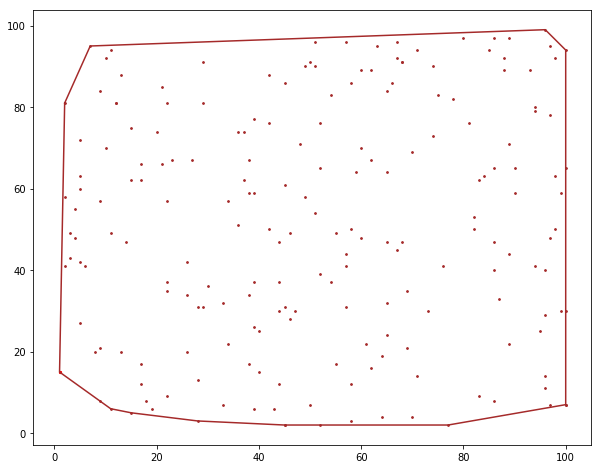

In [294]:
%matplotlib inline

# grafički prikaz točaka i pripadne konveksne ljuske
ConvexHull_array.append(ConvexHull_array[0])
x1, y1 = zip(*array_)
x2, y2 = zip(*ConvexHull_array) 
 


Hull = plt.figure(figsize=(10,8))
ax1 = Hull.add_subplot(111)
ax1.scatter( x1, y1, color='brown', s=3)
ax1.scatter( P_0[0], P_0[1], color='red', s=5 )
ax1.plot( x2, y2, color='brown')

plt.show()

Specijalni slučajevi. Točke iz područja kruga. 

<h2> Jarvis march </h2>

- opcenito o algoritmu
- pseudokod
- implementacija ( dio po dio )
- graf
- animacija?

<h2> Primjena </h2>

- nabrojati primjere
- implementacija ( dio po dio )

<h2> 3D konveksne ljuske ( konveksna zatvorenja ) </h2>
- nagovještaj 